In [46]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import optimize
from tqdm import tqdm
import os 
import pandas as pd 


class InterpolationModel:
    def __init__(self, priors, labels):
        self.model = interp1d(priors, labels)
    def __call__(self, unseen_point):
        if unseen_point < .5:
            return self.model(1-unseen_point)
        else:
            return self.model(unseen_point)

class RewardModel():
    def __init__(self):
        pass
    def R_function(self,postirior_plus):
        reward = np.max([postirior_plus, 1-postirior_plus])
        return reward
    def __call__(self,postiriors):
        return self.R_function(postiriors)



class SuccessProbability():
    def __init__(self, n_phases=2,amplitude=0.4, prob_ep=0.5, ep=1):
        self.n_phases = n_phases
        self.amplitude = amplitude
        self.possible_phases = np.array([-1.,1.])
        self.ep=ep
        self.prob_ep = prob_ep
        
    def NProb(self,outcome, amp,beta):
        p0=0
        for pep, ep in zip([self.prob_ep, 1-self.prob_ep],[self.ep, 1]):
            p0+= pep*np.exp(-abs(complex(np.sqrt(ep)*amp)+complex(beta))**2)
        if outcome == 0.:
            return p0
        else:
            return 1-p0

    def outcome_probability(self,outcome,prior_plus,beta,amp):
        prs = [prior_plus, 1-prior_plus]
        p=0
        for phase,pr in zip([1,-1], prs):
            p+= pr*self.NProb(outcome,phase*amp,beta)
        return p

    def postirior_probability(self,outcome, prior_plus, beta, amp):
        prob_ot = self.outcome_probability(outcome, prior_plus, beta, amp)
        return prior_plus*self.NProb(outcome, amp,beta)/prob_ot

    def J_intermmediate(self, prior_plus, beta, amplitude,next_J_interpolation):
        objective_function = 0
        for outcome in [0, 1]:
            postirior_plus = self.postirior_probability(outcome, prior_plus, beta, amplitude)
            objective_function += next_J_interpolation(postirior_plus)*self.outcome_probability(outcome, prior_plus, beta, amplitude)
        return -objective_function

for number_photodetectors in range(5,10):

    amplitude = .4
    ep=0.01
    suc = SuccessProbability(amplitude=amplitude/np.sqrt(number_photodetectors), prob_ep=.5, ep=ep)

    Npriors = 100
    priors = np.linspace(.5,1,Npriors)

    objective_functions = np.zeros((number_photodetectors+1,len(priors)))
    displacements = np.zeros((number_photodetectors,len(priors)))


    ### last layer ###
    modelito = RewardModel()
    for indp, pr in enumerate(priors):
        objective_functions[number_photodetectors, indp] = modelito(pr)

    for layer in tqdm(range(number_photodetectors)[::-1]):
        if layer == number_photodetectors-1:
            eff_amplitude=amplitude/np.sqrt(number_photodetectors)
        else:
            eff_amplitude = amplitude/np.sqrt(number_photodetectors)
        mod = InterpolationModel(priors,objective_functions[layer+1])
        for indp, pr in enumerate(priors):
            def suc1(beta):
                return suc.J_intermmediate(pr, beta[0], eff_amplitude, mod)
            f=optimize.dual_annealing(suc1, [(-1,1)], maxiter=200,no_local_search=True )
            objective_functions[layer,indp] = -f.fun
            displacements[layer,indp] = f.x[0]
            
    os.makedirs("resultsdp/{}/".format(ep),exist_ok=True)
    np.save("resultsdp/{}/{}L_objective_function".format(ep,number_photodetectors), objective_functions )
    np.save("resultsdp/{}/{}L_displacements".format(ep,number_photodetectors), objective_functions )    

  0%|          | 0/5 [00:00<?, ?it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 9/9 [01:15<00:00,  8.39s/it]


In [47]:
value=[]
for number_photodetectors in range(1,10):
    objfun = np.load("resultsdp/{}/{}L_objective_function.npy".format(ep,number_photodetectors))
    value.append(objfun[0,0])

In [60]:
??plt.xkcd

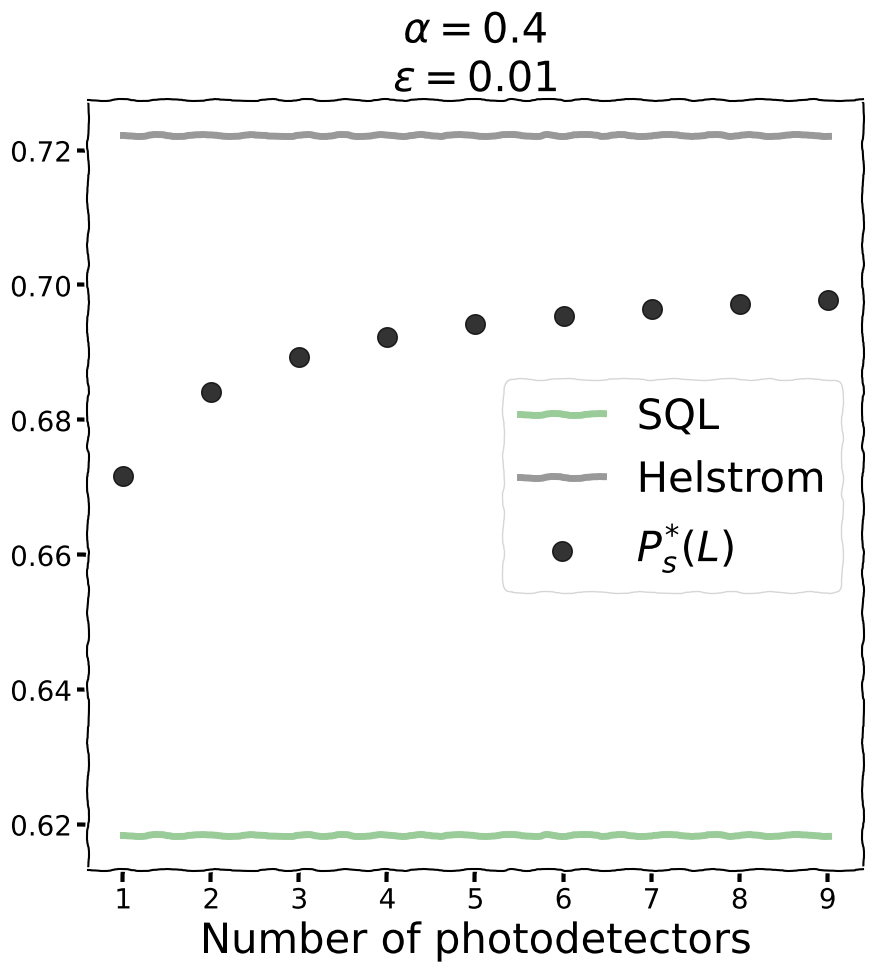

In [62]:
from helstrom import Helstrom
from math import erf

hel = Helstrom(alpha=0.4, ep = 0.01)
helstrom_avg = hel()

plt.xkcd(randomness=10)
plt.figure(figsize=(10,10))
plt.scatter(range(len(value)),value,alpha=0.8,color="black",s=200, label="$P^{*}_{s}(L)$")
plt.xticks(range(len(value)), [str(i+1) for i in range(len(value))],size=20)
plt.xlabel("Number of photodetectors",size=30)
plt.yticks(size=20)
plt.plot(range(len(value)), np.ones(len(value))*homodyne(0.4,ep=0.01), linewidth=5, color="green",alpha=0.4, label="SQL")
plt.plot(range(len(value)), np.ones(len(value))*helstrom_avg, color="black", linewidth=5,alpha=0.4, label="Helstrom")
plt.legend(prop={"size":30}, loc="best")
plt.title(r'$\alpha = 0.4$'+"\n"+r'$\epsilon = 0.01$', size=30)
plt.savefig("comparison_fixed_energy_and_damping.png")

In [10]:


def homodyne(a=0.4, ep=0.01):
    beta = np.sqrt(ep)*a
    return (2+ erf(a) + erf(beta))/4

In [12]:
plt.homodyne(0.4,ep=0.01)

0.6183758652979483